In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Open the .zip file
with zipfile.ZipFile('Retail_Transactions_Dataset.zip', 'r') as zip_ref:
    # Extract the CSV file
    with zip_ref.open('Retail_Transactions_Dataset.csv') as csv_file:
        # Read the CSV file using pandas
        data = pd.read_csv(csv_file)

In [3]:
# keep columns for the RGM analysis only
data = data [['Transaction_ID', 'Date', 'Customer_Name', 'Total_Items', 'Total_Cost']]
data.head()

,Transaction_ID,Date,Customer_Name,Total_Items,Total_Cost
0,1000000000,2022-01-21 06:27:29,Stacey Price,3,71.65
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,2,25.93
2,1000000002,2024-03-21 15:37:04,Lisa Graves,6,41.49
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,1,39.34
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,10,16.42


<b>Cohort Analysis</b>

The goal is to build mutually exclusive segments (cohorts). They are used to compare metrics across product/customer lifecycle. There are different types of cohorts: time, behavior, size.

In [4]:
len(data)

1000000

In [5]:
# We will use a randomly sampled 10% subset of this dataset
data = data.sample(frac=0.1, random_state=99)
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 852342 to 183354
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  100000 non-null  int64  
 1   date            100000 non-null  object 
 2   customer_name   100000 non-null  object 
 3   total_items     100000 non-null  int64  
 4   total_cost      100000 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


<b>Assign acquisition month cohort</b>

In [6]:
# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date
data['date'].min(), data['date'].max()

(datetime.date(2020, 1, 1), datetime.date(2024, 5, 18))

In [7]:
# Let's also keep only 12 months of our data for simplicity
data = data[data['date'] < dt.date(2020, 12, 31)]

In [8]:
# Create a function for getting month
def get_month(x): return dt.datetime(x.year, x.month, 1)
# Applyting function to date column
data['transaction_month'] = data['date'].apply(get_month)
# create cohort month
grouping = data.groupby('customer_name')['transaction_month']
data['cohort_month'] = grouping.transform('min')
data.head()

,transaction_id,date,customer_name,total_items,total_cost,transaction_month,cohort_month
481276,1000481276,2020-09-17,Rachel Boone,1,64.20,2020-09-01,2020-09-01
44322,1000044322,2020-03-13,Sandra Hernandez,8,9.63,2020-03-01,2020-03-01
927426,1000927426,2020-07-10,Jay Roberts,5,54.24,2020-07-01,2020-07-01
838168,1000838168,2020-11-09,Robert Mckinney,1,65.52,2020-11-01,2020-04-01
787035,1000787035,2020-09-07,Laura Clarke,5,71.23,2020-09-01,2020-09-01


<b>Extract integer values from data</b>

In [9]:
# define function to extract year, month, day integer values
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day= df[column].dt.day
    return year, month, day

<b>Assign time offset value</b>

In [10]:
tran_year, tran_month, _ = get_date_int(data, 'transaction_month')
cohort_year, cohort_month, _ = get_date_int(data, 'cohort_month')

years_diff = tran_year - cohort_year
months_diff = tran_month - cohort_month

data['cohort_index'] = years_diff * 12 + months_diff + 1
data.head()

,transaction_id,date,customer_name,total_items,total_cost,transaction_month,cohort_month,cohort_index
481276,1000481276,2020-09-17,Rachel Boone,1,64.20,2020-09-01,2020-09-01,1
44322,1000044322,2020-03-13,Sandra Hernandez,8,9.63,2020-03-01,2020-03-01,1
927426,1000927426,2020-07-10,Jay Roberts,5,54.24,2020-07-01,2020-07-01,1
838168,1000838168,2020-11-09,Robert Mckinney,1,65.52,2020-11-01,2020-04-01,8
787035,1000787035,2020-09-07,Laura Clarke,5,71.23,2020-09-01,2020-09-01,1


<b>Count monthly active customers from each cohort</b>

In [11]:
grouping = data.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['customer_name'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='cohort_month',
                                 columns='cohort_index',
                                 values='customer_name').fillna(0)
cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2020-01-01,1948.0,56.0,53.0,52.0,47.0,55.0,57.0,53.0,57.0,60.0,59.0,50.0
2020-02-01,1757.0,56.0,32.0,45.0,44.0,36.0,45.0,41.0,37.0,40.0,42.0,0.0
2020-03-01,1793.0,46.0,39.0,39.0,33.0,42.0,31.0,36.0,41.0,44.0,0.0,0.0
2020-04-01,1723.0,37.0,28.0,42.0,26.0,38.0,25.0,45.0,41.0,0.0,0.0,0.0
2020-05-01,1685.0,26.0,23.0,24.0,33.0,21.0,20.0,27.0,0.0,0.0,0.0,0.0
2020-06-01,1659.0,31.0,31.0,28.0,31.0,29.0,22.0,0.0,0.0,0.0,0.0,0.0
2020-07-01,1644.0,17.0,28.0,22.0,32.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-01,1651.0,30.0,30.0,33.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01,1531.0,22.0,24.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>Calculate Retention rate</b>

In [12]:
# Store the first column as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]
# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis=0).fillna(0)
# Review the retention table
retention.round(3) * 100

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2020-01-01,100.0,2.9,2.7,2.7,2.4,2.8,2.9,2.7,2.9,3.1,3.0,2.6
2020-02-01,100.0,3.2,1.8,2.6,2.5,2.0,2.6,2.3,2.1,2.3,2.4,0.0
2020-03-01,100.0,2.6,2.2,2.2,1.8,2.3,1.7,2.0,2.3,2.5,0.0,0.0
2020-04-01,100.0,2.1,1.6,2.4,1.5,2.2,1.5,2.6,2.4,0.0,0.0,0.0
2020-05-01,100.0,1.5,1.4,1.4,2.0,1.2,1.2,1.6,0.0,0.0,0.0,0.0
2020-06-01,100.0,1.9,1.9,1.7,1.9,1.7,1.3,0.0,0.0,0.0,0.0,0.0
2020-07-01,100.0,1.0,1.7,1.3,1.9,1.3,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-01,100.0,1.8,1.8,2.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01,100.0,1.4,1.6,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>Other metrics. Average quantity for each cohort.</b>

In [13]:
grouping = data.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['total_items'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='cohort_month',
                                     columns='cohort_index',
                                     values='total_items'
                                    ).fillna(0)
# Average quantity for each cohort
average_quantity.round(1)

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2020-01-01,5.5,5.6,5.1,4.7,5.8,5.3,5.6,5.8,5.0,6.0,5.6,6.1
2020-02-01,5.5,5.8,5.8,5.5,5.3,5.1,5.7,5.5,5.5,4.8,5.9,0.0
2020-03-01,5.5,5.1,5.8,5.9,5.2,5.1,5.5,6.1,5.9,5.1,0.0,0.0
2020-04-01,5.6,5.6,5.0,5.3,4.3,5.4,5.5,5.4,5.4,0.0,0.0,0.0
2020-05-01,5.4,5.3,4.9,6.0,5.7,5.1,5.6,4.4,0.0,0.0,0.0,0.0
2020-06-01,5.5,5.5,6.5,5.6,5.8,6.1,6.2,0.0,0.0,0.0,0.0,0.0
2020-07-01,5.3,5.2,5.4,5.4,5.5,5.2,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-01,5.5,5.6,6.3,6.2,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-01,5.5,5.0,5.6,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>Build the heatmap</b>

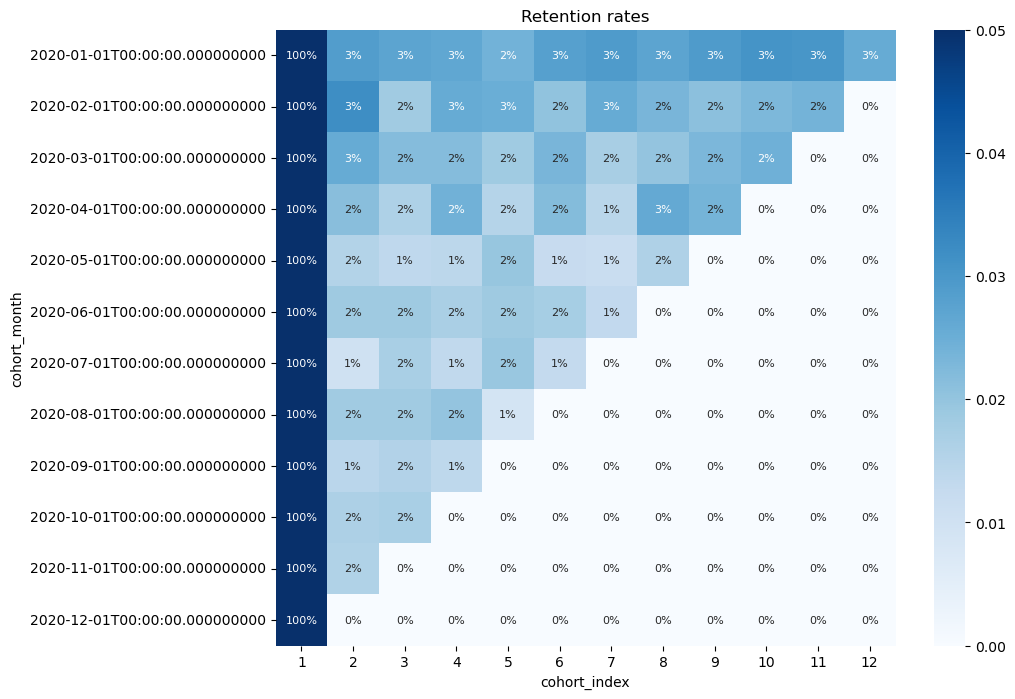

In [14]:
plt.figure(figsize=(10,8))
plt.title('Retention rates')
sns.heatmap(data = retention,
            annot = True,
            annot_kws={"size": 8},
            fmt = '.0%',
            vmin = 0.0,
            vmax = 0.05,
            cmap = 'Blues')
plt.show()

<b>RFM Segmentation</b>

Behavioral customer segmentation based on three metrics: Recency R (days since last customer transaction), Frequency F (number of transactions in the last 12 months), Monetary Value M (total spend in the last 12 months). The RFM values can be grouped in several ways: Percentiles e.g. quantiles, Pareto 80/20 cut, Custom - based on business knowledge. Our choice today is percentiles. We should sort customers first, then break them into pre-defined number of groups of equal size, assign a label to each group after.

<b>Data preparation steps</b>

In [15]:
# create a hypothetical snapshot_day data
snapshot_date = max(data.date) + dt.timedelta(days=1)

<b>Calculate RFM metrics</b>

In [16]:
# Aggreagate data on a customer level
datamart = data.groupby(['customer_name']).agg({
    'date': lambda x: (snapshot_date - x.max()).days,
    'transaction_id': 'count',
    'total_cost': 'sum'})
datamart.rename(columns = {'date': 'recency',
                           'transaction_id': 'frequency',
                           'total_cost': 'monetary_value'}, inplace=True)
datamart.head()

,recency,frequency,monetary_value
customer_name,,,
Aaron Adams,144,1,95.67
Aaron Allen,247,1,70.16
Aaron Anthony,22,1,83.60
Aaron Armstrong,47,1,9.25
Aaron Ayers,161,1,91.65


In [17]:
# Calculate quartile value for each column and name
# Recency quartile
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['recency'], 4, labels = r_labels)
datamart = datamart.assign(r = r_quartiles.values)

# Frequency and Monetary quartiles
f_labels = range(1,5)
m_labels = range(1,5)

# we use rank method because there is a lot of frequency values '1' and we cannot create bin with unique edges
f_quartiles = pd.qcut(datamart['frequency'].rank(method='first'), 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['monetary_value'], 4, labels = m_labels)

datamart = datamart.assign(f = f_quartiles.values)
datamart = datamart.assign(m = m_quartiles.values)

datamart.head()

,recency,frequency,monetary_value,r,f,m
customer_name,,,,,,
Aaron Adams,144,1,95.67,3,1,4
Aaron Allen,247,1,70.16,2,1,3
Aaron Anthony,22,1,83.60,4,1,4
Aaron Armstrong,47,1,9.25,4,1,1
Aaron Ayers,161,1,91.65,3,1,4


<b>Build RFM segment and RFM score</b>

In [18]:
# concatenate RFM quartile values to rfm_segment and sum RFM quatiles values to rfm_score
def join_rfm(x): return f"{int(x['r'])}{int(x['f'])}{int(x['m'])}"
datamart['rfm_segment'] = datamart.apply(join_rfm, axis=1)
datamart['rfm_score'] = datamart[['r','f','m']].sum(axis=1)
datamart.head()

,recency,frequency,monetary_value,r,f,m,rfm_segment,rfm_score
customer_name,,,,,,,,
Aaron Adams,144,1,95.67,3,1,4,314,8
Aaron Allen,247,1,70.16,2,1,3,213,6
Aaron Anthony,22,1,83.60,4,1,4,414,9
Aaron Armstrong,47,1,9.25,4,1,1,411,6
Aaron Ayers,161,1,91.65,3,1,4,314,8


<b>Largest RFM segments</b>

In [19]:
datamart.groupby('rfm_segment').size().sort_values(ascending=False)[:10]

rfm_segment
444    817
344    611
244    409
112    392
212    378
133    377
211    377
121    372
231    369
111    368
dtype: int64

<b>Summary metrics per RFM Score</b>

In [20]:
datamart.groupby('rfm_score').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']}).round(1)

recency frequency monetary_value      
             mean      mean           mean count
rfm_score                                       
3           314.6       1.0           18.0   368
4           284.8       1.0           27.0  1141
5           254.6       1.0           35.3  2088
6           219.6       1.0           42.4  3201
7           188.8       1.0           51.6  3563
8           156.0       1.0           58.7  3321
9           129.1       1.1           68.4  2692
10          109.8       1.3           83.2  1686
11           88.6       1.6          105.7  1113
12           39.4       2.5          147.4   817

<b>Grouping into named segments</b>

In [21]:
# use RFM score to group customers into Gold, Silver, and Bronze segments
def segment_me(df):
    if df['rfm_score'] >= 9:
        return 'Gold'
    elif (df['rfm_score'] >= 5) and (df['rfm_score'] < 9):
        return 'Silver'
    else: 
        return 'Bronze'
datamart['general_segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('general_segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)

recency frequency monetary_value       
                   mean      mean           mean  count
general_segment                                        
Bronze            292.1       1.0           24.8   1509
Gold              105.2       1.4           89.2   6308
Silver            199.3       1.0           48.3  12173

<b>Key k-means assumptions</b>

In [22]:
# symmetric distribution of variables (not skewed), variables with same average values, variables with same variance
datamart.describe()

,recency,frequency,monetary_value,rfm_score
count,19990.000000,19990.000000,19990.000000,19990.000000
mean,176.577189,1.134567,59.458472,7.501651
std,105.739754,0.495011,39.477209,2.123971
min,1.000000,1.000000,5.000000,3.000000
25%,84.000000,1.000000,31.000000,6.000000
50%,173.000000,1.000000,56.200000,7.000000
75%,267.000000,1.000000,80.840000,9.000000
max,365.000000,10.000000,601.520000,12.000000


We don't have equal mean and equal variance here

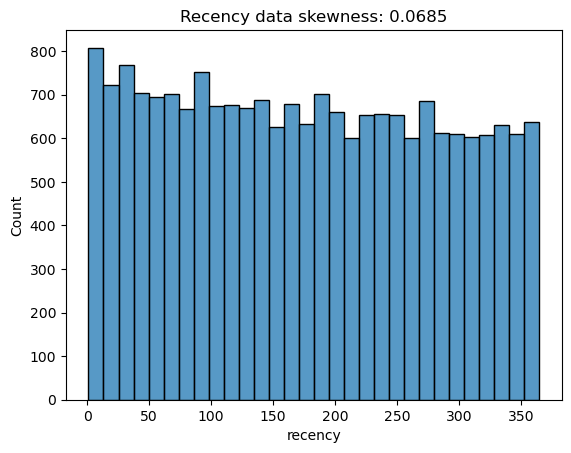

In [23]:
sns.histplot(data=datamart, x='recency', kde=False, bins=30)
# Calculate skewness
data_skewness = skew(datamart['recency'])
plt.title("Recency data skewness: {:.4f}".format(data_skewness))
plt.show()

In [24]:
# We are not going to normalize recency column
recency_data = pd.Series(datamart['recency'])

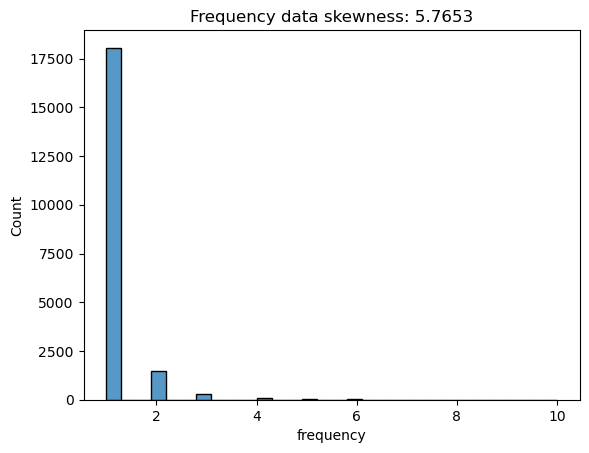

In [25]:
sns.histplot(data=datamart, x='frequency', kde=False, bins=30)
# Calculate skewness
data_skewness = skew(datamart['frequency'])
plt.title("Frequency data skewness: {:.4f}".format(data_skewness))
plt.show()

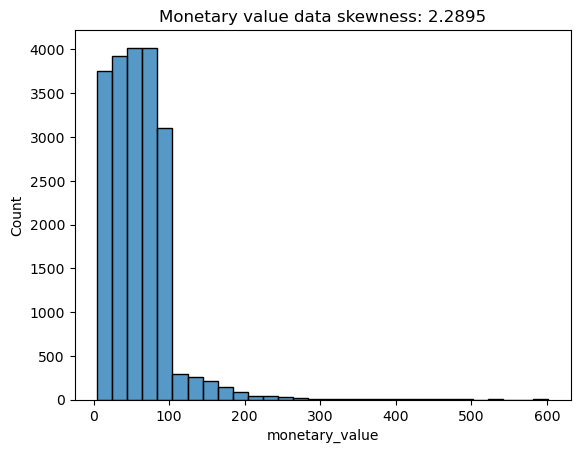

In [26]:
sns.histplot(data=datamart, x='monetary_value', kde=False, bins=30)
# Calculate skewness
data_skewness = skew(datamart['monetary_value'])
plt.title("Monetary value data skewness: {:.4f}".format(data_skewness))
plt.show()

All of our datasets have right-skewed distribution, especially frequency. We will make transform it using numpy to manage skeweness.

<b>Power transformation</b>

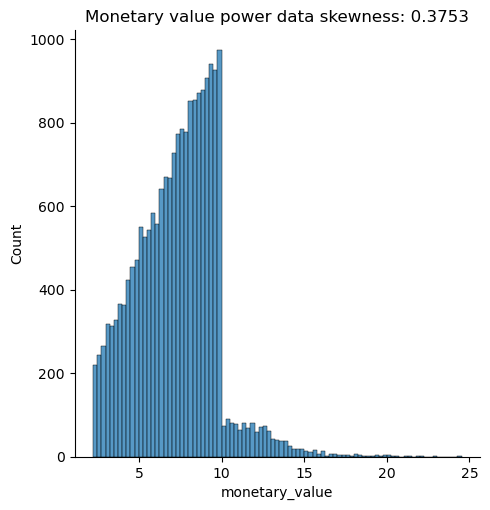

In [27]:
# transform monetary value data using square root
monetary_value_power = datamart['monetary_value'] ** 0.5
# Calculate skewness
data_skewness = skew(monetary_value_power)
sns.displot(monetary_value_power)
plt.title("Monetary value power data skewness: {:.4f}".format(data_skewness))
plt.show()

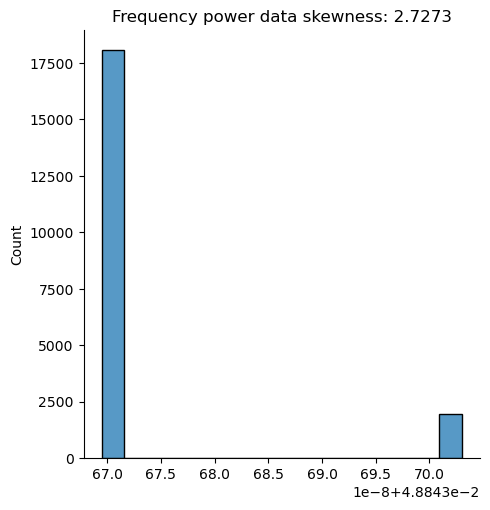

In [28]:
# Transform frequency data using Box Cox
# Extract the 'frequency' column from datamart
frequency_data = datamart['frequency']
# Find the smallest non-zero value
offset = frequency_data[frequency_data > 0].min()
# Apply Box-Cox transformation with offset
transformed_frequency, _ = boxcox(frequency_data + offset)
# Calculate skewness
data_skewness = skew(transformed_frequency)
sns.displot(transformed_frequency)
plt.title("Frequency power data skewness: {:.4f}".format(data_skewness))
plt.show()

<b>Centering variables with different means</b>

K-Means works well on variables with the same mean. Centering variables is done by subtracting average value from each observation.

In [29]:
datamart_rfm = datamart[['recency', 'frequency', 'monetary_value']]		
datamart_centered = datamart_rfm - datamart_rfm.mean()
print('datamart_rfm: \n', datamart_rfm.describe().round(2), '\n\ndatamart_centered: \n', 
      datamart_centered.describe().round(2))

datamart_rfm: 
         recency  frequency  monetary_value
count  19990.00   19990.00        19990.00
mean     176.58       1.13           59.46
std      105.74       0.50           39.48
min        1.00       1.00            5.00
25%       84.00       1.00           31.00
50%      173.00       1.00           56.20
75%      267.00       1.00           80.84
max      365.00      10.00          601.52 

datamart_centered: 
         recency  frequency  monetary_value
count  19990.00   19990.00        19990.00
mean      -0.00       0.00           -0.00
std      105.74       0.50           39.48
min     -175.58      -0.13          -54.46
25%      -92.58      -0.13          -28.46
50%       -3.58      -0.13           -3.26
75%       90.42      -0.13           21.38
max      188.42       8.87          542.06


<b>Scaling variables with different variance</b>

K-Means works better on variables with the same variance / standard deviation. Scaling variables is done by dividing them by standard deviation each.

In [30]:
datamart_scaled = datamart_rfm / datamart_rfm.std()
print('datamart_rfm: \n', datamart_rfm.describe().round(2), '\n\ndatamart_scaled: \n', 
      datamart_scaled.describe().round(2))

datamart_rfm: 
         recency  frequency  monetary_value
count  19990.00   19990.00        19990.00
mean     176.58       1.13           59.46
std      105.74       0.50           39.48
min        1.00       1.00            5.00
25%       84.00       1.00           31.00
50%      173.00       1.00           56.20
75%      267.00       1.00           80.84
max      365.00      10.00          601.52 

datamart_scaled: 
         recency  frequency  monetary_value
count  19990.00   19990.00        19990.00
mean       1.67       2.29            1.51
std        1.00       1.00            1.00
min        0.01       2.02            0.13
25%        0.79       2.02            0.79
50%        1.64       2.02            1.42
75%        2.53       2.02            2.05
max        3.45      20.20           15.24


<b>Combining centering and scaling</b>

Subtract mean and divide my standard deviation manually or use a scaler from scikit-learn (returns numpy.ndarray)

In [31]:
scaler = StandardScaler()
scaler.fit(datamart_rfm)
datamart_normalized = scaler.transform(datamart_rfm)
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [-0.  0. -0.]
std:  [1. 1. 1.]


<b>Repeat the sequence with unskewed data</b>

In [32]:
unskewed_data = pd.DataFrame({'recency': recency_data, 
                              'frequency': transformed_frequency, 
                              'monetary_value': monetary_value_power})
scaler.fit(unskewed_data)
datamart_normalized = scaler.transform(unskewed_data)
datamart_normalized = pd.DataFrame(unskewed_data, columns=['recency', 'frequency', 'monetary_value'])
# We have datamart_rfm and datamart_normalized objects.
datamart_rfm.attrs['name'] = 'datamart_rfm'
datamart_normalized.attrs['name'] = 'datamart_normalized'

<b>Define the number of clusters</b>

1. Mathematical methods - silhouette coefficient
2. Experimentation and interpretation
3. Visual methods - elbow criterion

For datamart_rfm n_clusters = 2, the average silhouette score is 0.5459417186472141
For datamart_rfm n_clusters = 3, the average silhouette score is 0.45534143061409293
For datamart_rfm n_clusters = 4, the average silhouette score is 0.39059592553292616
For datamart_rfm n_clusters = 5, the average silhouette score is 0.4103676617074304
For datamart_rfm n_clusters = 6, the average silhouette score is 0.36323278296086753
For datamart_rfm n_clusters = 7, the average silhouette score is 0.36340874506448667
For datamart_rfm n_clusters = 8, the average silhouette score is 0.34892976906167994
For datamart_rfm n_clusters = 9, the average silhouette score is 0.3526737892138753
For datamart_rfm n_clusters = 10, the average silhouette score is 0.35309682387822683


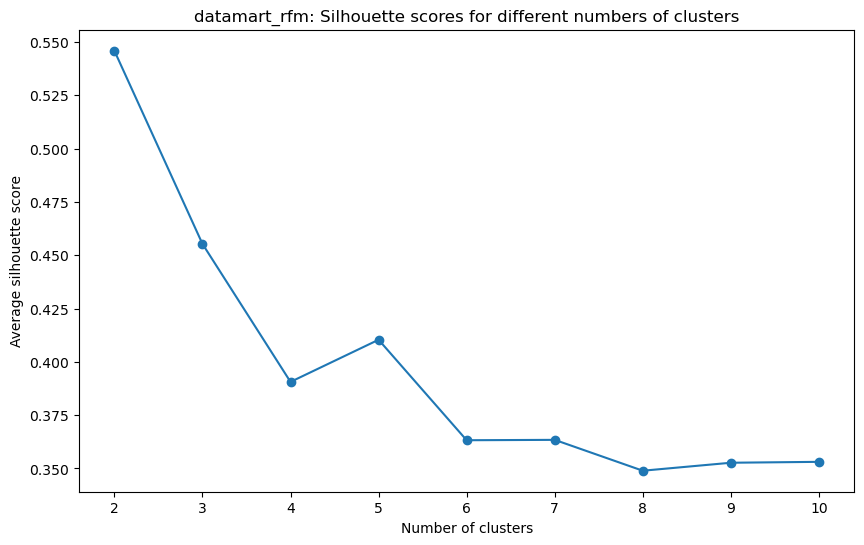

The optimal number of clusters datamart_rfm is 2


In [33]:
# We will use first two methods
# Range of number of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Create function to evaluate silhouette score for each number of clusters
def silhouette_score_evaluation(df, clusters):
    # List to store the average silhouette scores
    silhouette_avg_scores = []
    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters
        clusterer = KMeans(n_clusters=n_clusters, random_state=99)
        cluster_labels = clusterer.fit_predict(df)
        
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_avg_scores.append(silhouette_avg)
        print(f"For {df.attrs['name']} n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}")
    
    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
    plt.title(f"{df.attrs['name']}: Silhouette scores for different numbers of clusters")
    plt.xlabel("Number of clusters")
    plt.ylabel("Average silhouette score")
    plt.show()

    # Optimal number of clusters
    optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]
    print(f"The optimal number of clusters {df.attrs['name']} is {optimal_n_clusters}")
    
silhouette_score_evaluation(datamart_rfm, range_n_clusters)

For datamart_normalized n_clusters = 2, the average silhouette score is 0.6272582980870055
For datamart_normalized n_clusters = 3, the average silhouette score is 0.5878332644718108
For datamart_normalized n_clusters = 4, the average silhouette score is 0.5696347300305138
For datamart_normalized n_clusters = 5, the average silhouette score is 0.5577442836799327
For datamart_normalized n_clusters = 6, the average silhouette score is 0.5475970631879287
For datamart_normalized n_clusters = 7, the average silhouette score is 0.5382671279646548
For datamart_normalized n_clusters = 8, the average silhouette score is 0.5310423090884555
For datamart_normalized n_clusters = 9, the average silhouette score is 0.5246792189718066
For datamart_normalized n_clusters = 10, the average silhouette score is 0.5181384308747341


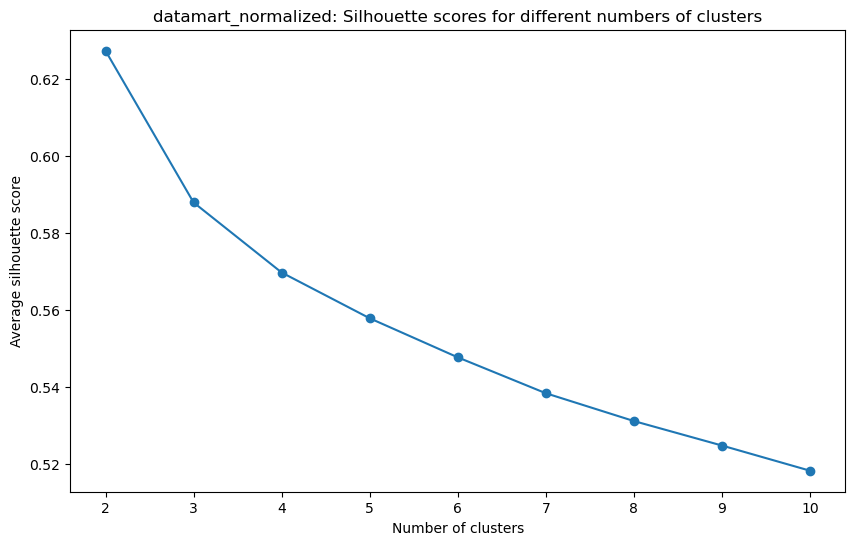

The optimal number of clusters datamart_normalized is 2


In [34]:
silhouette_score_evaluation(datamart_normalized, range_n_clusters)

In [35]:
# Create function for clusters interpretation
def clusters_interpretation(df, clusters):
    for n_clusters in clusters:
        # Initialize the clusterer with n_clusters
        clusterer = KMeans(n_clusters=n_clusters, random_state=99)
        # Compute k-means clustering on pre-processed data
        clusterer.fit(df)
        # Extract cluster labels from labels_ attribute
        cluster_labels = clusterer.labels_
        # Create a cluster label column in the original df
        new_df = df.assign(Cluster = cluster_labels)
        # Calculate average RFM values and size for each cluster
        grouped = new_df.groupby(['Cluster']).agg({
            'recency': 'mean',
            'frequency': 'mean',
            'monetary_value': ['mean', 'count'],
        }).round(0)
        print(f"The result of a {n_clusters}-cluster solution for {df.attrs['name']}: \n")
        print(grouped, '\n\n')

In [36]:
clusters_interpretation(datamart_rfm, range_n_clusters)

The result of a 2-cluster solution for datamart_rfm: 

        recency frequency monetary_value       
           mean      mean           mean  count
Cluster                                        
0          88.0       1.0           64.0  10324
1         271.0       1.0           55.0   9666 


The result of a 3-cluster solution for datamart_rfm: 

        recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0         179.0       1.0           57.0  6615
1         302.0       1.0           54.0  6398
2          59.0       1.0           67.0  6977 


The result of a 4-cluster solution for datamart_rfm: 

        recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0         319.0       1.0           53.0  4683
1          44.0       1.0           69.0  5279
2         134.0       1.0           58.0  5121
3         227.0       1.0

In [37]:
clusters_interpretation(datamart_normalized, range_n_clusters)

The result of a 2-cluster solution for datamart_normalized: 

        recency frequency monetary_value       
           mean      mean           mean  count
Cluster                                        
0         271.0       0.0            7.0   9662
1          88.0       0.0            8.0  10328 


The result of a 3-cluster solution for datamart_normalized: 

        recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0          59.0       0.0            8.0  7015
1         303.0       0.0            7.0  6356
2         180.0       0.0            7.0  6619 


The result of a 4-cluster solution for datamart_normalized: 

        recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0          44.0       0.0            8.0  5235
1         319.0       0.0            7.0  4718
2         226.0       0.0            7.0  4944
3   

<b>Approaches to build customer personas</b>

1. Snake plots
2. Relative importance of cluster attributes compared to population
3. Summary statistics for each cluster e.g. average RFM values using clusters interpretation method (will not be covered here)

In [38]:
# Create function for adding cluster column to dataset
def add_clusters_column(df, clusters):
    # Initialize the clusterer with n_clusters
    clusterer = KMeans(n_clusters=clusters, random_state=99)
    # Compute k-means clustering on pre-processed data
    clusterer.fit(df)
    # Extract cluster labels from labels_ attribute
    cluster_labels = clusterer.labels_
    # Create a cluster label column in the original df
    new_df = df.assign(cluster = cluster_labels)
    return new_df

In [39]:
# We choose 3 clusters as optimal value for both datasets
datamart_rfm_clusters = add_clusters_column(datamart_rfm, 3)
datamart_normalized_clusters = add_clusters_column(datamart_normalized, 3)

In [40]:
# To make snake plot we melt data into a long format so RFM values and metric names are stored in 1 column each
datamart_rfm_clusters_melt = pd.melt(datamart_rfm_clusters.reset_index(),
                                            id_vars=['customer_name', 'cluster'],
                                            value_vars=['recency', 'frequency', 'monetary_value'],
                                            var_name='attribute',
                                            value_name='value')
datamart_normalized_clusters_melt = pd.melt(datamart_normalized_clusters.reset_index(),
                                            id_vars=['customer_name', 'cluster'],
                                            value_vars=['recency', 'frequency', 'monetary_value'],
                                            var_name='attribute',
                                            value_name='value')
datamart_normalized_clusters_melt.head()

,customer_name,cluster,attribute,value
0,Aaron Adams,2,recency,144.0
1,Aaron Allen,1,recency,247.0
2,Aaron Anthony,0,recency,22.0
3,Aaron Armstrong,0,recency,47.0
4,Aaron Ayers,2,recency,161.0


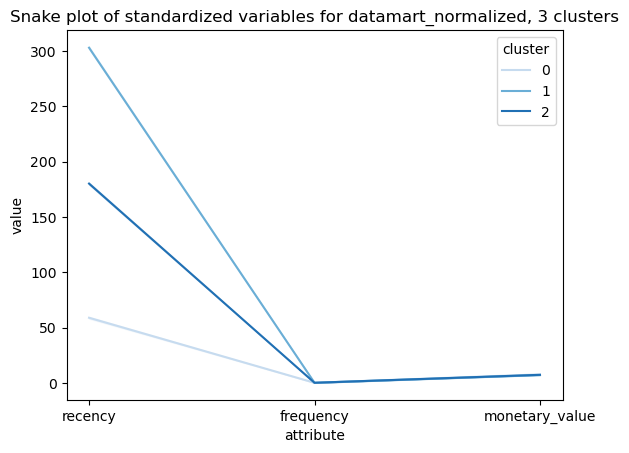

In [41]:
# Visualize a snake plot
plt.title('Snake plot of standardized variables for datamart_normalized, 3 clusters')
sns.lineplot(x='attribute', y='value', hue='cluster', data=datamart_normalized_clusters_melt, palette=sns.color_palette("Blues", 3))
plt.show()

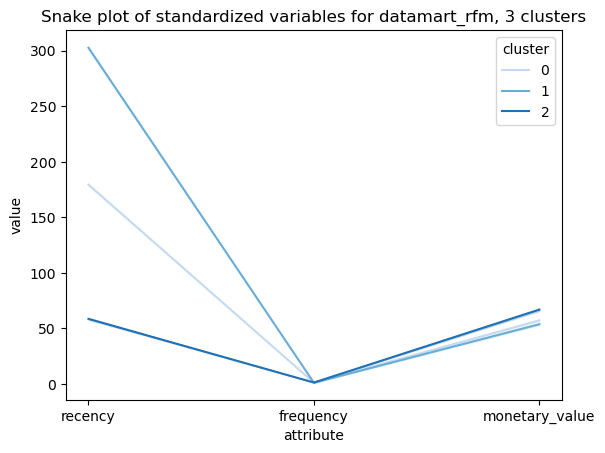

In [42]:
# Visualize a snake plot
plt.title('Snake plot of standardized variables for datamart_rfm, 3 clusters')
sns.lineplot(x='attribute', y='value', hue='cluster', data=datamart_rfm_clusters_melt, palette=sns.color_palette("Blues", 3))
plt.show()

<b>Relative importance of segment attributes</b>

Useful technique to identify relative importance of each segment's attribute. 
1. Calculate average values of each cluster
2. Calculate average values of population
3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

The further the ratio from 0, the more important that attribute is for a segment relative to the total population

In [43]:
rfm_cluster_avg = datamart_rfm_clusters.groupby(['cluster']).mean()
rfm_population_avg = datamart_rfm.mean()
rfm_relative_imp = (rfm_cluster_avg / rfm_population_avg) - 1
rfm_relative_imp.round(2)

,recency,frequency,monetary_value
cluster,,,
0,0.02,-0.03,-0.04
1,0.71,-0.09,-0.10
2,-0.67,0.11,0.12


In [44]:
norm_cluster_avg = datamart_normalized_clusters.groupby(['cluster']).mean()
norm_population_avg = datamart_normalized.mean()
norm_relative_imp = (norm_cluster_avg / norm_population_avg) - 1
norm_relative_imp.round(2)

,recency,frequency,monetary_value
cluster,,,
0,-0.67,0.0,0.05
1,0.72,-0.0,-0.04
2,0.02,-0.0,-0.01


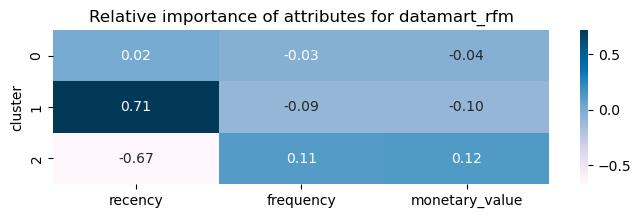

In [45]:
# Plot a heatmap for easier interpretation
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes for datamart_rfm')
sns.heatmap(data=rfm_relative_imp, annot=True, fmt='.2f', cmap='PuBu')
plt.show()

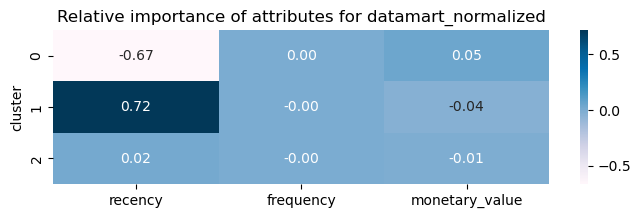

In [46]:
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes for datamart_normalized')
sns.heatmap(data=norm_relative_imp, annot=True, fmt='.2f', cmap='PuBu')
plt.show()